In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

np.random.seed(0)
torch.manual_seed(0)

In [4]:
# 生成reber语言
def REBER(n, lenth=None):
    N = 0
    R = []
    while N < n:
        r, s = "B", 0 # 初始文字，状态
        transfer_map = {
            0 : [("T", 1), ("P", 2)],
            1 : [("S", 1), ("X", 3)],
            2 : [("T", 2), ("V", 4)],
            3 : [("X", 2), ("S", 5)],
            4 : [("P", 3), ("V", 5)]
        }

        while s != 5 :
            if np.random.rand() > 0.5:
                next_state = transfer_map[s][0]
            else:
                next_state = transfer_map[s][1]
            r += next_state[0]
            s = next_state[1]

        r += "E"
        
        if lenth:
            if len(r) == lenth:
                R.append(r)
                N += 1
        else:
            R.append(r)
            N += 1
    
    return R

train_data = REBER(256, 10)
print(train_data)

['BTXXTTTVVE', 'BPVPXTVPSE', 'BPTVPXTVVE', 'BPTVPXVPSE', 'BPTVPXVPSE', 'BPTTTTVPSE', 'BTXXTTTVVE', 'BPTVPXVPSE', 'BPTTTTTVVE', 'BPTTTTTVVE', 'BTSSSSSXSE', 'BPTVPXVPSE', 'BTXXTTVPSE', 'BPTVPXTVVE', 'BPTTTTVPSE', 'BPTVPXVPSE', 'BPTTTTTVVE', 'BPTTTTVPSE', 'BPTTVPXVVE', 'BTSSSSSXSE', 'BTXXVPXVVE', 'BPTTTTVPSE', 'BPTTTTTVVE', 'BTSSXXTVVE', 'BPVPXTTVVE', 'BTSSSXXVVE', 'BPTTTTTVVE', 'BTXXTTTVVE', 'BPTVPXTVVE', 'BPVPXTTVVE', 'BPTVPXVPSE', 'BTXXTTTVVE', 'BPTVPXVPSE', 'BPTTTTTVVE', 'BPTTTTVPSE', 'BTSSSXXVVE', 'BPTVPXTVVE', 'BPTTTTVPSE', 'BPTTTTTVVE', 'BPTVPXVPSE', 'BPVPXTVPSE', 'BTSSXXTVVE', 'BTSXXTVPSE', 'BTXXVPXVVE', 'BTXXTTVPSE', 'BTSXXTTVVE', 'BTSSSXXVVE', 'BTSSSSSXSE', 'BPTTTTTVVE', 'BPVPXTTVVE', 'BTXXTTVPSE', 'BTXXTTTVVE', 'BTSSSXXVVE', 'BPTTTTVPSE', 'BTSXXTVPSE', 'BTXXVPXVVE', 'BPTTTTVPSE', 'BPTTVPXVVE', 'BTSSXXVPSE', 'BTXXTTVPSE', 'BTSSXXTVVE', 'BTSXXTTVVE', 'BPTTVPXVVE', 'BTSSSXXVVE', 'BTXXVPXVVE', 'BTXXVPXVVE', 'BPVPXTVPSE', 'BPTVPXVPSE', 'BPVPXTTVVE', 'BTSSSSSXSE', 'BTSXXTTVVE', 'BPVP

In [5]:
char_list = list("BTPSXVE")
char_num  = len(char_list)
char_map  = {c : char_list.index(c) for c in char_list}
char_map

{'B': 0, 'T': 1, 'P': 2, 'S': 3, 'X': 4, 'V': 5, 'E': 6}

In [6]:
# 数据生成器，用于读取批量数据
# 每个序列的前 L-1 位作为输入，后 L-1个作为监督信号
def data_iter(batch_size, data):
    # 数据大小
    data_num = len(data)
    seq_num  = len(data[0])
    char_num = 7
    # 随机排列
    permutation = np.arange(data_num)
    np.random.shuffle(permutation)
    permutation = permutation.tolist()
    # 每次取 batch_size 个
    for i in range(0, data_num, batch_size):
        # 每个 batch 的下标
        indices = permutation[i:i+batch_size]
        
        # 按照时间顺序变换
        batch_n_list = [] # 得到每一个字符对应的数字
        batch_n_advisor_list = [] # 监督信号
        for j in indices:
            # 对batch中下标为j的字符串数字化
            n_list = []
            for k in data[j]:
                # 获取该字符对应的数字
                n_list.append(char_map[k])
            
            batch_n_list.append(n_list[:-1])
            batch_n_advisor_list.append(n_list[1:])

        # 将其传入one_hot函数，得到(batch*seq*char)的tensor
        batch_seq_one_hot = F.one_hot(torch.tensor(batch_n_list), char_num)
        
        # 改为seq first的tensor，转置前两维
        seq_batch_one_hot = batch_seq_one_hot.transpose(0, 1)
        
        # advisor的tensor(batch*seq*char)
        batch_seq_advisor = torch.tensor(batch_n_advisor_list)
        seq_batch_advisor = batch_seq_advisor.transpose(0, 1) # 转置
        
        yield seq_batch_one_hot, seq_batch_advisor
    
data_iter_ = data_iter(5, train_data)
for _ in range(1):
    data = next(data_iter_)
    print(data)

(tensor([[[1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 1, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 1, 0],
         [0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0],
         [0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0]],

        [[0, 0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0],
         [0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0]],

        [[0, 0, 0, 0, 1, 0, 0],
         [0, 1, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 1,

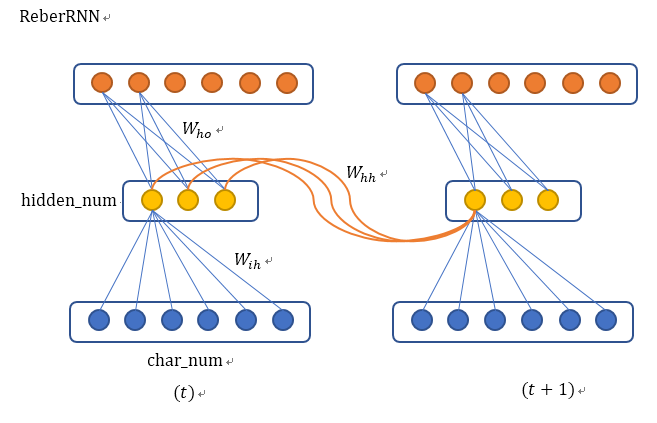

In [18]:
class ReberRNN(nn.Module):
    def __init__(self, char_num, hidden_num):
        super().__init__()
        
        # parameters
        self.hidden_num = hidden_num
        W_ih = torch.empty(hidden_num, char_num)
        W_hh = torch.empty(hidden_num, hidden_num)
        W_ho = torch.empty(char_num, hidden_num)
        
        # initialization
        for W in [W_ih, W_hh, W_ho]:
            nn.init.normal_(W)
        
        # rigister
        self.W_ih = nn.Parameter(W_ih)
        self.W_hh = nn.Parameter(W_hh)
        self.W_ho = nn.Parameter(W_ho)
        
    def forward(self, input):
        # 隐藏层 (hidden, 1)
        batch_hidden_layer = torch.empty(self.hidden_num).unsqueeze(1)

        # 输出
        output = torch.tensor([])
        
        # 输入数据为 (seq, batch, input)
        # 希望得到   (seq, batch, output)
        # 遍历所有seq，计算隐藏层更新，保存到output中
        for i in range(input.size(0)):
            # 当前seq的batch_onehot
            # 为计算权重与one_hot相乘，需要使用matmul的多维相乘
            # 需要使用 (hidden, input) * (batch, input, 1) = (batch, hidden, 1)
            batch_onehot = input[i].unsqueeze(2)
            batch_hidden_layer_linear = self.W_ih.matmul(batch_onehot) + self.W_hh.matmul(batch_hidden_layer)
            # 激活函数
            batch_hidden_layer = torch.tanh(batch_hidden_layer_linear)
            # 得到(batch, hidden, 1)的数据
            
            # 计算输出 (output, hidden) * (batch, hidden, 1) = (batch, output, 1)
            batch_output = self.W_ho.matmul(batch_hidden_layer).squeeze(2)
            # 添加进输出tensor
            output = torch.cat((output, batch_output.unsqueeze(0)), 0)
        
        return output

In [8]:
# myNN = ReberRNN(7, 10)
# for p in myNN.parameters():
#     print(p)

In [9]:
# myNN = ReberRNN(7, 10)
    
# data_iter_ = data_iter(5, train_data)
# for _ in range(1):
#     INPUT, TARGET = next(data_iter_)
#     output = myNN(INPUT.float())
#     print(output)

In [20]:
myNN = ReberRNN(7, 10)

# 训练阶段
epoch_num  = 20000
batch_size = 16
learning_rate = 1e-3

# 生成优化器
optimizer = optim.SGD(myNN.parameters(), lr=learning_rate)

for epoch in range(epoch_num):
    for INPUT, TARGET in data_iter(batch_size, train_data):
        # forward
        output = myNN(INPUT.float())
#         print(output.size())
#         print(output[0:2])
        Loss = F.cross_entropy(output.reshape(-1, 7), TARGET.reshape(-1))
        
        # update
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()

    if epoch % 2000 == 0:
        print(" for epoch %d\t, Loss is %s" % (epoch, Loss.item()))

 for epoch 0	, Loss is 4.280735015869141
 for epoch 2000	, Loss is 0.8874995708465576
 for epoch 4000	, Loss is 0.6334093809127808
 for epoch 6000	, Loss is 0.4282624125480652
 for epoch 8000	, Loss is 0.3907242715358734
 for epoch 10000	, Loss is 0.364754319190979
 for epoch 12000	, Loss is 0.40083956718444824
 for epoch 14000	, Loss is 0.3520098924636841
 for epoch 16000	, Loss is 0.32028695940971375
 for epoch 18000	, Loss is 0.3341372609138489


In [21]:
# 预测一个序列
seq = 'BTXXTTTVVE'
# 转为 seq_one_hot
n_list = []
for i in seq:
    # 获取该字符对应的数字
    n_list.append(char_map[i])
seq_one_hot = F.one_hot(torch.tensor(n_list))

test_output = myNN(seq_one_hot[:-1].unsqueeze(1).float())
test_output

tensor([[[ 0.8214,  6.3170,  6.1863, -2.6123, -3.4117,  1.8813,  1.2942]],

        [[-2.4002, -2.9905, -6.9967,  2.6702,  2.1025, -1.6020, -1.4827]],

        [[-3.7199, -0.6555, -2.0816, -0.3791,  3.1010, -1.0426, -2.8568]],

        [[-0.5105,  3.9110, -1.4727, -3.8203, -0.2508,  3.2246, -0.9000]],

        [[ 1.4498,  7.3350,  1.8675, -0.5679,  3.2385, -0.6825, -0.5928]],

        [[-0.7220,  4.3916, -0.5214, -5.9524,  0.1137,  4.1712, -7.5094]],

        [[-1.4827, -4.7390,  0.8385, -0.3511, -2.2036,  6.1320, -6.8101]],

        [[-0.3472, -3.7065, -3.7135,  1.2030, -1.6850,  6.7935, -2.5920]],

        [[ 0.8187, -5.1818,  1.9823,  2.1749, -4.8639, -1.7566,  8.5804]]],
       grad_fn=<CatBackward>)